## Colab 환경 구축


### 활용 라이브러리 (고정)

*   [torch==1.9.0](https://pytorch.org/)
*   [pytorch-lightning==1.4.2](https://pypi.org/project/pytorch-lightning/1.4.2/)
*   [transformers](https://pypi.org/project/transformers/)


In [ ]:
!pip3 install torch==1.9.0 torchvision torchaudio
!pip3 install pytorch-lightning==1.4.2
!pip3 install transformers
!pip3 install datasets

### Transformer(트랜스포머)


```
- 2017년 구글이 발표한 논문 "Attention is All You Need" 에서 나온 모델
- seq2seq(sequence-to-sequence) 구조와 마찬가지로 Encoder(인코더)-Decoder(디코더)로 구성
```

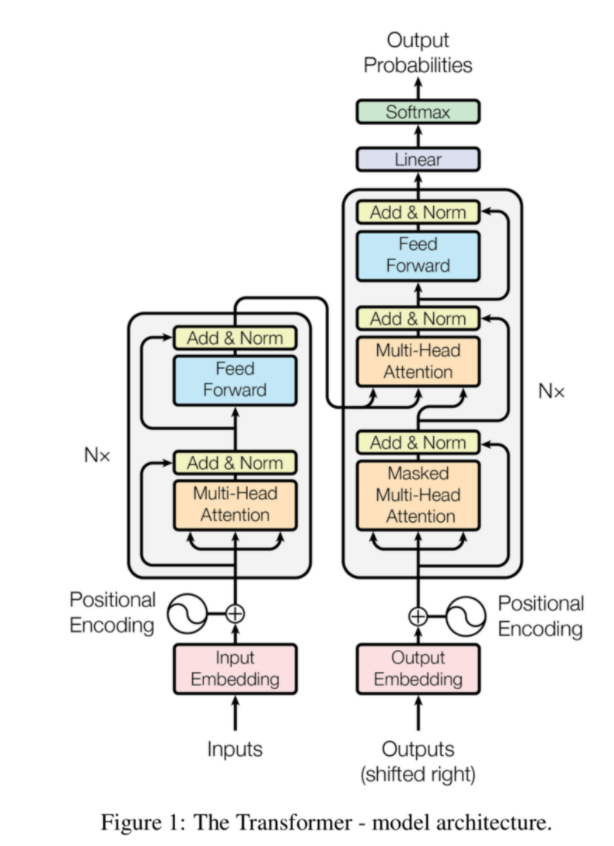



### [Huggingface](https://huggingface.co/)
github : https://github.com/huggingface/transformers

- **transformers** : BERT, GPT, BART 등 트랜스포머 기반의 모델을 쉽게 사용할 수 있는 패키지

- 기존 : 개발자가 PyTorch로 layer, model 모두 선언

- transformers 라이브러리 활용 : 사전학습한 모델 불러와 API 처럼 훈련 가능



### [BERT](https://huggingface.co/transformers/model_doc/bert.html#bertmodel)

- tokenizer(토크나이저) 
- model(가중치를 갖고 있는 bert 모델)
- 인코더만 활용한 모델

In [ ]:
from transformers import BertTokenizer, BertModel

# tokenizer, model 정의
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # 가지고 올 수 있음
model = BertModel.from_pretrained('bert-base-cased') # ('')사용자가 정해서 사용


# "" 입력한 단어를 먼저 토크나이저가 쪼개줌, 단어의 vokab을 숫자로 바꿔줌, 전처리의 과정을 통해서 txt를 숫자로 변환하는 과정
# tokenizer에서 알아서 token으로 숫자로 변화해주는 과정까지 해줌
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")  # 구현이 다 되어 있음/ 개발자는 토크나이저로 불러와서 사용하면 됨
print('inputs:',inputs)  # 인풋 인덱스 확인 ( 텐서 타입 )
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print(last_hidden_states) # 모델 마지막 레이어 값(float tpye 벡터, 고차원의 벡터)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


inputs: {'input_ids': tensor([[  101,  8667,   117,  1139,  3676,  1110, 10509,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[[ 0.5132,  0.5097,  0.1991,  ..., -0.3900,  0.4053, -0.2315],
         [ 0.5395, -0.3658,  0.6667,  ..., -0.3920,  0.2505,  0.0202],
         [ 0.7767,  0.6823,  0.7110,  ..., -0.0420, -0.3718,  0.3748],
         ...,
         [ 0.3555,  0.4486,  0.6175,  ..., -0.0388, -0.2631,  0.3514],
         [ 0.7927, -0.1282,  0.2737,  ..., -0.5220,  0.4836,  0.0937],
         [ 1.2903,  1.0356,  0.5054,  ..., -0.4344,  1.1973, -0.4236]]],
       grad_fn=<NativeLayerNormBackward>)


In [ ]:
import os, csv
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import torch
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AdamW

# *BERT* 모델을 활용한 Text Classification


## 1. Preprocess and Prepare Dataset
### 1) Dataset : [TREC](https://huggingface.co/datasets/trec)

* 질문 분류 데이터셋(Question classification dataset)
* train : 5,452
* test : 500
* number of labels : 6 (DESC (0), ENTY (1), ABBR (2), HUM (3), NUM (4), LOC)

```
{
    "label-coarse": 1,
    "label-fine": 2,
    "text": "What fowl grabs the spotlight after the Chinese Year of the Monkey ?"
}
```


---

### 2) 데이터 전처리

모델의 입력값 준비


1.   **input_ids** : 문장을 토크나이즈해서 인덱스 값으로 변환
2.   **attention_mask** : padding된 부분에 대해 학습에 영향을 받지 않기 위해 처리해주는 입력값, BERT tokenizer의 경우 1은 attention에 영향을 받는 토큰, 0은 영향을 받지 않는 토큰을 나타냄
3.   **token_type_ids** : 두 개의 시퀀스를 입력으로 활용할 때 0과 1로 문장의 토큰 값 분리. [CLS] 토큰은 문장의 시작을 의미, [SEP]는 문장이 분리되는 부분을 의미하는 토큰

[CLS] 문장 [SEP]
  -> 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]])


Next sentence prediction (다음 문장을 예측하는)
앞, 뒤
이두개를 분리하기 위한 토큰 00000 / 111111/

bert는 문장 두개만 들어가게되어있음

[CLS] 문장 [SEP] 문장2 [SEP]
  -> 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0][1, 1, 1, 1, 1, 1, 1]])




### transformer
attention 
input으로 들어가는 토큰의 활용되는거

이미지, 텍스트 -> 숫자  -> tensor -> Dataloader -> 입력(input_ids, attention_mask, token_tpye_ids)


### Toeknizer

inputs = tokenizer ("I am a good boy", return_tensors="pt")  
input : ""
input_id(index) : I/ am / a / good /boy tensor( 100, 32 , 42 ,103, 28)
I -> vocab 100번 (vocab은 사전에 정의되어 있는 사전이라고 생각하면됨)

문장의 길이가 다 일정해야됨,그래서 패딩이 들어가게됨
input1 : "i am a good boy"
input2 : "Hello, i am fine thank you"
padding=maxsequencelength

최대 길이보다 짧은 데이터셋은 다 패딩으로 채워짐
attention_mask : 패딩임을 알려주는 입력값
attention모델을 수행하기 위한 token


### 전처리

이미지 -> numpy -> transform -> 모델입력

cnn) 이미지 -> 커널 -> linear


-- tokenizer--  
text -> 숫자 -> tensor ->모델입력


NLP) 모델 -> linear -> 결과물을 벡터형태로 받음


In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, max_seq_length):
      self.data = data
      self.tokenizer = tokenizer
      self.max_seq_length = max_seq_length

    def get_input_features(self, examples):
      inputs = self.tokenizer(examples["text"], padding="max_length", max_length=self.max_seq_length, truncation=True, return_tensors="pt")
      labels = torch.tensor(examples["label-coarse"], dtype=torch.long)      
      return inputs['input_ids'].squeeze(), inputs['token_type_ids'].squeeze(), inputs['attention_mask'].squeeze(), labels

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      input_ids, token_type_ids, attention_mask, labels = self.get_input_features(self.data[idx])        
      return input_ids, token_type_ids, attention_mask, labels 

In [ ]:
class ClassificationDatamodule(LightningDataModule):
    def __init__(self, batch_size, max_seq_length):
        super().__init__()
        self.batch_size = batch_size
        self.max_seq_length = max_seq_length
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

    def setup(self):
      # load dataset
      trec_datasets = load_dataset("trec")
      train_data = trec_datasets["train"]
      test_data = trec_datasets["test"]
      
      self.train_dataset = ClassificationDataset(train_data, self.tokenizer, self.max_seq_length)
      self.test_dataset = ClassificationDataset(test_data, self.tokenizer, self.max_seq_length)
      # print(self.train_dataset[0]) # 확인용

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [ ]:
# seed (랜덤시드 고정)
pl.seed_everything(42)

# google drive mount 후 본인 drive 폴더 경로 내에 데이터 및 모델 저장
path = os.path.join('/content/drive/MyDrive/AISoftware/week2')
model_folder = os.path.join(path, 'model')
if not os.path.exists(model_folder): os.makedirs(model_folder)

batch_size = 64
max_seq_length = 64

dm = ClassificationDatamodule(batch_size, max_seq_length)
dm.setup()

Global seed set to 42


Downloading:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/336k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset trec downloaded and prepared to /root/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9. Subsequent calls will reuse this data.


## 2. Build Model

- 모델 : BERT 
- Task : text classification

Bert -> 768차원 벡터 -> linear -> classification

In [ ]:
class Model(LightningModule):
    def __init__(self):
        super(Model, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6) #AutoModelForSequencdClassification 모델 : 주로 sentence 분류에 사용됨
        self.learning_rate = 3e-5

    def forward(self, input_ids, token_type_ids, attention_mask, labels=None):
        outputs = self.model(input_ids, token_type_ids, attention_mask, labels=labels) # 인풋 정보 모델에 넣음

        loss = outputs.loss # 분류를 했을때 로스의 차이
        logits = outputs.logits # 소프트 맥스 전에 되는 값의 벡터가 나오게된다 생각하면됨

        return loss, logits

    def training_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, labels = batch  # 가지고온 인풋 정보

        loss, logits = self.forward(input_ids, token_type_ids, attention_mask, labels)  # [batch_size, max_seq_len]
        
        self.log_dict({
            'train_loss' : loss
            })
        return loss

    def test_step(self, batch, batch_idx):
        input_ids, token_type_ids, attention_mask, labels = batch

        loss, logits = self.forward(input_ids, token_type_ids, attention_mask)  # [batch_size, max_seq_len]

        pred_labels = torch.argmax(logits, dim=-1)

        return {'input_ids': input_ids.cpu(), 'pred_labels': pred_labels.cpu(), 'answer_labels': labels.cpu()}

    def test_epoch_end(self, outputs):
        input_ids = []
        pred_labels = []
        answer_labels = []
        for output in outputs:
            input_ids.append(output['input_ids'])
            pred_labels.append(output['pred_labels'])
            answer_labels.append(output['answer_labels'])

        input_ids = torch.cat(input_ids) # [#test, ]
        pred_labels = torch.cat(pred_labels)
        answer_labels = torch.cat(answer_labels)

        result_dir = os.path.join(model_folder, 'result.csv')  
        correct_dir = os.path.join(model_folder, 'accuracy.txt')  
        cor_f = open(correct_dir, 'w', encoding='utf-8')
        tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        
        with open(result_dir, 'w', encoding='utf-8', newline='') as f:
            wr = csv.writer(f, delimiter='\t')
            wr.writerow(['text', 'pred', 'answer', 'correct'])
            correct_list = []

            for input, pred, answer in zip(input_ids, pred_labels, answer_labels):
                input_tokens = tokenizer.decode(input, input_type='token', clean_up_tokenization_spaces=True, skip_special_tokens=True) #

                if pred == answer: correct = True
                else: correct = False
                correct_list.append(correct)

                wr.writerow([input_tokens, pred, answer, correct])

            accuracy = np.mean(np.array(correct_list))
            cor_f.write(f'{accuracy}\n')
        print('[Sentiment Analysis] predict tag is dumped at ', result_dir)
        print('[Sentiment Analysis] accuracy is dumped at ', correct_dir)
        print('Accuracy : ', accuracy)
        cor_f.close()
        return torch.tensor(0)

    def configure_optimizers(self):
      param_optimizer = list(self.named_parameters())
      no_decay = ["bias", "gamma", "beta"]
      optimizer_grouped_parameters = [
              {
                  "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                  "weight_decay_rate": 0.01
                  },
              {
                  "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                  "weight_decay_rate": 0.0
                  },
              ]
      optimizer = AdamW(
                  optimizer_grouped_parameters,
                  lr=self.learning_rate,
              )
      return optimizer 

## Training

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='train_loss', dirpath=model_folder, filename='{epoch:02d}-{train_loss:.2f}')
logger = TensorBoardLogger(model_folder, name='tensorboard')

model = Model()
# create the trainer -- Single GPU training
trainer = Trainer(
    max_epochs=20, gpus=1, auto_select_gpus=True,
    logger = logger,
    callbacks=[
               checkpoint_callback,
               LearningRateMonitor(logging_interval='step'),
               EarlyStopping(monitor='train_loss', verbose=True, patience=5)
              ],
            )

trainer.fit(model, dm.train_dataloader()) # 학습

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Training: -1it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.469
Metric train_loss improved by 0.432 >= min_delta = 0.0. New best score: 0.036
Metric train_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.007
Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.006
Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003
Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002
Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.002
Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001
Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001
Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


In [ ]:
# 성능 TEST
trainer.test(model, dm.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[Sentiment Analysis] predict tag is dumped at  /content/drive/MyDrive/AISoftware/week2/model/result.csv
[Sentiment Analysis] accuracy is dumped at  /content/drive/MyDrive/AISoftware/week2/model/accuracy.txt
Accuracy :  0.976
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]